<a href="https://colab.research.google.com/github/Untick/IrisID_gr2/blob/Gaidash-Alexey-folder/Identification_of_patients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подключим библиотеки

In [ ]:
# Подключение класса для создания нейронной сети прямого распространения
from tensorflow.keras.models import Sequential 
# Подключение класса для создания полносвязного слоя
from tensorflow.keras.layers import Dense 
# Подключение оптимизатора
from tensorflow.keras.optimizers import Adam 
# Подключение утилит для to_categorical
from tensorflow.keras import utils 
# Подключение библиотеки для загрузки изображений
from tensorflow.keras.preprocessing import image 
# Подключение библиотеки для работы с массивами
import numpy as np 
# Подключение библиотек для отрисовки изображений
import matplotlib.pyplot as plt 
# Подключение модуля для работы с файлами
import os

from PIL import Image;
# для распаковки архивов
import zipfile;
# для рзавёртывания изображения на плоскости
import cv2;
# Вывод изображения в ноутбуке, а не в консоли или файле
%matplotlib inline

In [ ]:
# Загрузка датасета из облака
import gdown
gdown.download('https://drive.google.com/uc?id=1ZAXRuE6ly8nJG-eGFTkD9Pn663ihCedB', None, quiet=True)

'Iris_ID.zip'

In [ ]:
# Распаковываем архив Iris_ID.zip в папку Iris_ID
!unzip -q Iris_ID.zip

In [ ]:
# Распакуем вложенные архивы
# Путь к директории с базой
base_dir = '/content/Iris_ID';

for patch in os.listdir(base_dir):
  with zipfile.ZipFile(base_dir + '/' + patch, 'r') as zip_ref:
    zip_ref.extractall('dataset' + '/' + patch.split('.')[0]);

In [ ]:
def gauss2D(shape=(586,2304),sigma=0.5):
  m,n = [(ss-1.)/2. for ss in shape];
  y,x = np.ogrid[-m:m+1,-n:n+1];
  h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) );
  h[ h < np.finfo(h.dtype).eps*h.max() ] = 0;
  sumh = h.sum();
  if sumh != 0:
      h /= sumh;
  return h;

In [ ]:
# Получим данные изображений в виде масива
datasetPath = '/content/dataset';

# Создание пустого списка для загрузки изображений обучающей выборки
x_train = [];
# Создание списка для меток классов
y_train = [];
num_class = 0;

# Перебираем каждую директорию
for dir in os.listdir(datasetPath):
  # Преобразовываем каждую картинку в массив байт
  for img in os.listdir(datasetPath + '/' + dir):
    i = Image.open(datasetPath + '/' + dir + '/' + img);
    width, height = i.size;

    im = image.img_to_array(image.load_img(datasetPath + '/' + dir + '/' + img,
                            target_size=(int(height / 2), int(width / 2)),
                            color_mode='grayscale'))

    

    margin = 0.9; # Cut off the outer 10% of the image
    # развернём изображения на плоскость    
    # Do the polar rotation along 1024 angular steps with a radius of 256 pixels.
    polar_img = cv2.warpPolar(im, (int(height), int(width + width * 2)), (im.shape[0] / 2 ,im.shape[1] / 2), im.shape[1] / 2 * margin * 0.3, cv2.WARP_POLAR_LINEAR);
    # Rotate it sideways to be more visually pleasing
    polar_img = cv2.rotate(polar_img, cv2.ROTATE_90_COUNTERCLOCKWISE);

    arr = gauss2D(polar_img.shape, 0.5);
    x_train.append(image.img_to_array(polar_img));

    if 'L' not in img:
      spliterator = 'R';
      id = img.split(spliterator + '_')[0];
      y_train.append(num_class);
    elif 'R' not in img:
      spliterator = 'L';
      id = img.split(spliterator + '_')[0];
      y_train.append(num_class);
    
    num_class = num_class + 1;

# Преобразование в numpy-массив загруженных изображений и меток классов
x_train = np.array(x_train);
y_train = np.array(y_train);

# Вывод размерностей
print('Размер массива x_train', x_train.shape);
print('Размер массива y_train', y_train.shape);

Размер массива x_train (384, 576, 2304, 1)
Размер массива y_train (384,)


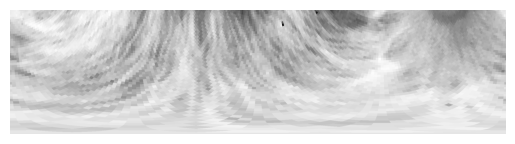

In [ ]:
imgs = np.array([x_train[i] for i in range(1)]);

# Соединение изображения в одну линию
imgs = np.concatenate(imgs)

# # Создание поля для изображения
# plt.figure(figsize=(60, 1))

# Отрисовка итогового изображения
plt.imshow(imgs, cmap='Greys_r')    

# Без сетки
plt.grid(False) 

# Без осей
plt.axis('off')  

# Вывод результата
plt.show() 

In [ ]:
# преобразуем все значения к дробным
x_train_normalization = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2]);
x_train_normalization = x_train_normalization.astype('float32') / 255;

# Сделаем категоризацию макеров
y_train_categorical = utils.to_categorical(y_train, num_class);

В качестве первичного теста создадим нейронную сеть с линейными слоями

In [ ]:
# Приступим к созданию нейронных сетей

ns_1 = Sequential();

ns_1.add(Dense(128, input_dim=x_train.shape[1] * x_train.shape[2], activation='relu'));
ns_1.add(Dense(128, activation='relu'));
ns_1.add(Dense(num_class, activation='softmax'));

ns_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']);

# выведем данные о нейронной сети
print(ns_1.summary());

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               169869440 
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 384)               49536     
                                                                 
Total params: 169,935,488
Trainable params: 169,935,488
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = ns_1.fit(x_train_normalization, y_train_categorical, batch_size=10, epochs=10, verbose=1);

Epoch 1/10
39/39 [==============================] - 108s 3s/step - loss: 60.9844 - accuracy: 0.0000e+00
Epoch 2/10
39/39 [==============================] - 102s 3s/step - loss: 5.9527 - accuracy: 0.0000e+00
Epoch 3/10
39/39 [==============================] - 103s 3s/step - loss: 5.9526 - accuracy: 0.0000e+00
Epoch 4/10
39/39 [==============================] - 102s 3s/step - loss: 5.9526 - accuracy: 0.0000e+00
Epoch 5/10
39/39 [==============================] - 103s 3s/step - loss: 5.9526 - accuracy: 0.0000e+00
Epoch 6/10
39/39 [==============================] - 102s 3s/step - loss: 5.9525 - accuracy: 0.0026
Epoch 7/10
39/39 [==============================] - 103s 3s/step - loss: 5.9526 - accuracy: 0.0000e+00
Epoch 8/10
39/39 [==============================] - 102s 3s/step - loss: 5.9526 - accuracy: 0.0000e+00
Epoch 9/10
39/39 [==============================] - 102s 3s/step - loss: 5.9526 - accuracy: 0.0000e+00
Epoch 10/10
39/39 [==============================] - 114s 3s/step - loss: 5.

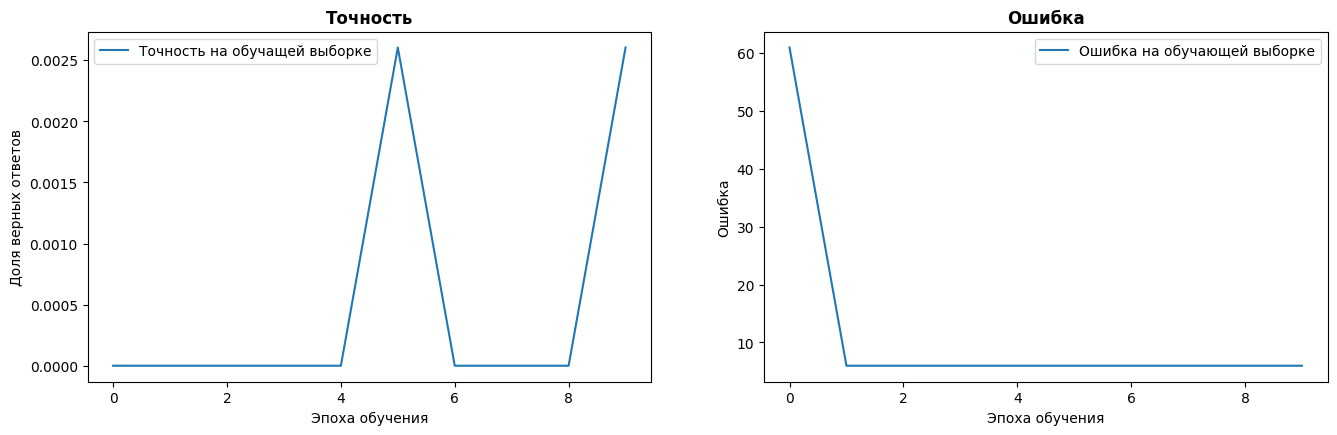

In [ ]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.title('Точность', fontweight='bold')
plt.plot(history.history['accuracy'], label='Точность на обучащей выборке')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.subplot(2, 2, 2)
plt.title('Ошибка', fontweight='bold')
plt.plot(history.history['loss'], label='Ошибка на обучающей выборке')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()

plt.show()

Точность такой модели крайне мала, а значит такая модель нейронной сети
не подходит для решения данной задачи.

Следующим испытанием возьмём свёрточную нейронную сеть.